在AlexNet的第一层，卷积窗口的形状是11x11。 由于ImageNet中大多数图像的宽和高比MNIST图像的多10倍以上，因此，需要一个更大的卷积窗口来捕获目标。 第二层中的卷积窗口形状被缩减为5x5，然后是3x3。 此外，在第一层、第二层和第五层卷积层之后，加入窗口形状为3x3、步幅为2的最大汇聚层。 而且，AlexNet的卷积通道数目是LeNet的10倍。

在最后一个卷积层后有两个全连接层，分别有4096个输出。 这两个巨大的全连接层拥有将近1GB的模型参数。 由于早期GPU显存有限，原版的AlexNet采用了双数据流设计，使得每个GPU只负责存储和计算模型的一半参数。 幸运的是，现在GPU显存相对充裕，所以现在很少需要跨GPU分解模型（因此，本书的AlexNet模型在这方面与原始论文稍有不同）。

此外，AlexNet将sigmoid激活函数改为更简单的ReLU激活函数。 一方面，ReLU激活函数的计算更简单，它不需要如sigmoid激活函数那般复杂的求幂运算。 另一方面，当使用不同的参数初始化方法时，ReLU激活函数使训练模型更加容易。 当sigmoid激活函数的输出非常接近于0或1时，这些区域的梯度几乎为0，因此反向传播无法继续更新一些模型参数。 相反，ReLU激活函数在正区间的梯度总是1。 因此，如果模型参数没有正确初始化，sigmoid函数可能在正区间内得到几乎为0的梯度，从而使模型无法得到有效的训练。

AlexNet通过Dropout控制全连接层的模型复杂度，而LeNet只使用了权重衰减。 为了进一步扩充数据，AlexNet在训练时增加了大量的图像增强数据，如翻转、裁切和变色。 这使得模型更健壮，更大的样本量有效地减少了过拟合。 在 13.1节中更详细地讨论数据扩增。

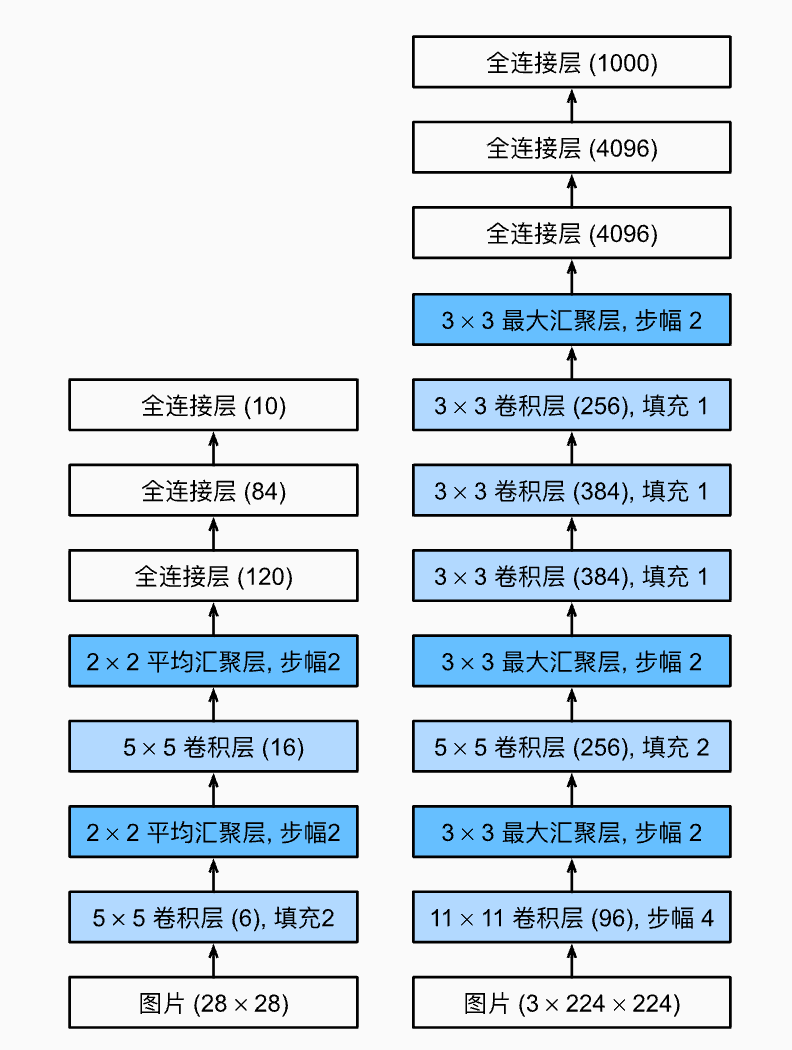

In [ ]:
import torch
from torch import nn
import sys
sys.path.append('..')
from tools import tool_pytorch_017 as ty

# 构建AlexNet网络结构
net = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

# 查看AlexNet的分层结构输出
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)
    
batch_size = 128
train_iter, test_iter = ty.load_data_fashion_mnist(batch_size, resize=224)

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = ty.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(ty.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


#@save
def train_AlexNet(net, train_iter, test_iter, num_epochs, lr, device):
    """训练AlexNet模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = ty.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = ty.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = ty.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], ty.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    
lr, num_epochs = 0.01, 10
train_AlexNet(net, train_iter, test_iter, num_epochs, lr, ty.try_gpu())